## Country flags

### Import packages

In [5]:
import numpy as np

import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import seaborn as sns
import colorsys

### Scrape image sources from wikipedia article

In [12]:
URL = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

sources = soup.find_all('img', class_='thumbborder')
sources[1]

<img alt="" class="thumbborder" data-file-height="900" data-file-width="1350" decoding="async" height="15" src="//upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/23px-Flag_of_India.svg.png" srcset="//upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/35px-Flag_of_India.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/45px-Flag_of_India.svg.png 2x" width="23"/>

### Extract the URLs from the scraped source data

In [13]:
def get_url(source, start, end):
    src = str(source)
    pos_start = src.find(start)
    pos_end = src.find(end)
    url = 'https://' + src[pos_start:pos_end+len(end)]
    return url

In [14]:
URLs = [get_url(source, "upload.wikimedia.org/", ".svg.png") for source in sources]

### Read the images from the URLs and convert them to RGB scale

In [15]:
def get_RGB_colors_from_url(URL):
    response = requests.get(URL)
    img = Image.open(BytesIO(response.content))
    RGB_image = img.convert('RGB')
    width, height = RGB_image.size
    RGB_color = np.empty((width, height, 3))
    for i in range(width):
        for j in range(height):
            #RGB_colors[i, j, 0], RGB_colors[i, j, 1], RGB_colors[i, j, 2] = RGB_image.getpixel((i, j))
            RGB_color[i, j, :] = RGB_image.getpixel((i, j))
    return RGB_color

In [17]:
RGB_colors = [get_RGB_colors_from_url(URL) for URL in URLs]

### Calculate average wavelength

In [18]:
def get_average_wavelength(RGB_color):
    mean_color = np.mean(np.mean(RGB_color, axis=1), axis=0)
    hue = colorsys.rgb_to_hls(mean_color[0], mean_color[1], mean_color[2])
    wavelength = 620 - 170 * hue[0]
    return wavelength

In [19]:
wavelengths = [get_average_wavelength(RGB_color) for RGB_color in RGB_colors]

### Visualize colors

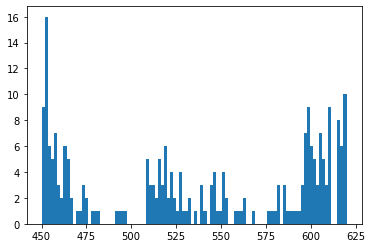

In [20]:
plt.hist(wavelengths, bins=100)
plt.show()

C:\Users\Fabio\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

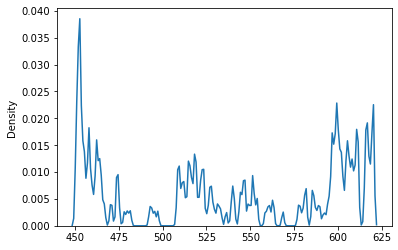

In [21]:
sns.kdeplot(data=wavelengths, bw=0.01)

C:\Users\Fabio\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

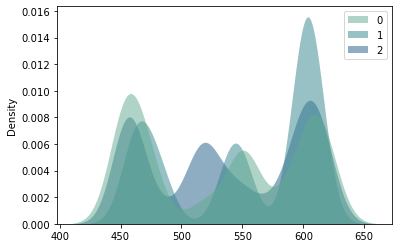

In [22]:
sns.kdeplot(
   data=[wavelengths[:20], wavelengths[20:30], wavelengths[30:]],#, x="total_bill", hue="size",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0, bw=0.2
)